<a id='top'></a><a name='top'></a>
# Chapter 6: Text Classification Algorithms

**Blueprints for Text Analysis Using Python**

* [Introduction](#introduction)
* [6.0 Imports and Setup](#6.0)
* [6.1 Introducing the Java Development Tools Bug Dataset](#6.1)
* [6.2 Blueprint: Building a Text Classification System](#6.2)
    - [6.2.1 Step 1: Data Preparation](#6.2.1)
    - [6.2.2 Step 2: Train-Test Split](#6.2.2)
    - [6.2.3 Step 3: Training the Machine Learning Model](#6.2.3)
    - [6.2.4 Step 4: Model Evaluation](#6.2.4)
* [6.3 Final Blueprint for Text Classification](#6.3)
* [6.4 Blueprint: Using Cross-Validation to Estimate Realistic Accuracy Metrics](#6.4)
* [6.5 Blueprint: Performing Hyperparameter Tuning with Grid Search](#6.5)
* [6.6 Blueprint Recap and Conclusion](#6.6)

This chapter is about using supervised learning for a classification problem.

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* Java Development Tools Bug dataset: [script](#eclipse_jdt.csv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz)

### Explore

* Applying supervised learning.
* Splitting data into train and test sets.
* Validating model performance using accuracy measures.
* Applying cross-validation techniques. 
* Different types of text classification.

---
<a name='6.0'></a><a id='6.0'></a>
# 6.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
# Start with clean project
!rm -f *.gz 
!rm -f *.py 
!rm -f *.txt

In [2]:
req_file = "requirements_06.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
tqdm
watermark

Writing requirements_06.txt


In [4]:
import sys

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Installing packages
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00


In [5]:
%%writefile imports.py
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import html
import locale
import pprint
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from spacy.tokens import Span, Token
from tqdm.auto import tqdm
from watermark import watermark

Writing imports.py


In [6]:
!isort imports.py
!cat imports.py

# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import html
import locale
import pprint
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from spacy.tokens import Span, Token
from tqdm.auto import tqdm
from watermark import watermark


In [7]:
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import html
import locale
import pprint
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from spacy.tokens import Span, Token
from tqdm.auto import tqdm
from watermark import watermark

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 7.9.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.10.147+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

sys       : 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
seaborn   : 0.12.2
re        : 2.2.1
pandas    : 1.4.4
spacy     : 3.5.1
matplotlib: 3.7.1



In [9]:
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

<a id='eclipse_jdt.csv.gz'></a><a name='eclipse_jdt.csv.gz'></a>
### Dataset: eclipse_jdt.csv.gz
<a href="#top">[back to top]</a>

In [1]:
file = "eclipse_jdt.csv.gz"
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz
!ls -l {file}

-rw-r--r--  1 gb  staff  13689872 Mar 31 19:56 eclipse_jdt.csv.gz


---
<a name='6.1'></a><a id='6.1'></a>
# 6.1 Introducing the Java Development Tools Bug Dataset
<a href="#top">[back to top]</a>

Here we classify bugs and issues raised during the development of the Java Development Tools (JDT) open source project.

We load a CSV file that contains the JDT bugs dataset. This dataset contains 45,296 bugs and some of the available characteristics for each bug

In [11]:
# 45K
df_orig = pd.read_csv(file)
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45296 entries, 0 to 45295
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Issue_id          45296 non-null  int64  
 1   Priority          45296 non-null  object 
 2   Component         45296 non-null  object 
 3   Duplicated_issue  7688 non-null   float64
 4   Title             45296 non-null  object 
 5   Description       45253 non-null  object 
 6   Status            45296 non-null  object 
 7   Resolution        45296 non-null  object 
 8   Version           45296 non-null  object 
 9   Created_time      45296 non-null  object 
 10  Resolved_time     45296 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.8+ MB


In [12]:
df = df_orig.sample(n=20_000, replace=True, random_state=42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 15795 to 3754
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Issue_id          20000 non-null  int64  
 1   Priority          20000 non-null  object 
 2   Component         20000 non-null  object 
 3   Duplicated_issue  3403 non-null   float64
 4   Title             20000 non-null  object 
 5   Description       19982 non-null  object 
 6   Status            20000 non-null  object 
 7   Resolution        20000 non-null  object 
 8   Version           20000 non-null  object 
 9   Created_time      20000 non-null  object 
 10  Resolved_time     20000 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.8+ MB


In [13]:
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

,Issue_id,Priority,Component,Title,Description
9777,27301,P3,Core,Cannot use CVS keywords in code templates,I wanted to generate my own file template whic...
37574,223495,P3,Core,[assist] Member types of missing parametrized ...,build I20080318-0800; ; 1) create p/A.java; pa...


In [14]:
# Explore a single bug report
df = df.drop(columns=['Duplicated_issue'])
df.sample(1, random_state=123).T

,44513
Issue_id,404003
Priority,P3
Component,Core
Title,[1.8][dom ast] CCE in ASTConverter on cast to ...
Description,BETA_JAVA8; ; public class BugA {; \tvoid foo(...
Status,CLOSED
Resolution,DUPLICATE
Version,4.3
Created_time,2013-03-21 06:35:00 -0400
Resolved_time,2013-10-14 21:04:46 -0400


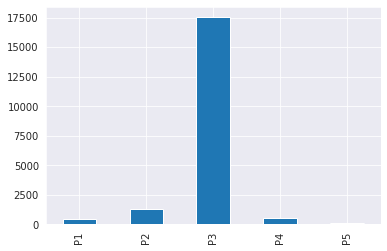

In [15]:
# Distribution of bug reports across different priorities
df['Priority'].value_counts().sort_index().plot(kind='bar')
plt.show()

Check how many bugs are reported against each component of the JDT.

In [16]:
df['Component'].value_counts()

UI       7808
Core     5976
Debug    3273
Text     2644
APT       164
Doc       135
Name: Component, dtype: int64

---
<a name='6.2'></a><a id='6.2'></a>
# 6.2 Blueprint: Building a Text Classification system
<a href="#top">[back to top]</a>

This text classification system will use supervised learning.

<a name='6.2.1'></a><a id='6.2.1'></a>
## 6.2.1 Step 1: Data Preparation
<a href="#top">[back to top]</a>

Before building the text classfication model, we must clean the data, and restructure the data-structure of the dataset suitable for the selected machine learning algorithm.

In [17]:
print(df.columns)

Index(['Issue_id', 'Priority', 'Component', 'Title', 'Description', 'Status',
       'Resolution', 'Version', 'Created_time', 'Resolved_time'],
      dtype='object')


In [18]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [19]:
df['text'] = df['text'].progress_apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

progress-bar:   0%|          | 0/19982 [00:00<?, ?it/s]

,Priority,text
6895,P3,Extension point for Java decompiler Currently ...
33043,P3,Refactoring History Property page showing in w...


<a name='6.2.2'></a><a id='6.2.2'></a>
## 6.2.2 Step 2: Train-Test Split
<a href="#top">[back to top]</a>

The default ratio is 80-20. 80 observations will become part of the train split and 20 observations will become part of the test split. 

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text'],
    df['Priority'],
    test_size=0.2,
    random_state=42,
    stratify=df['Priority']
)

print('Size of Training Data: ', X_train.shape[0])
print('Size of Test Data: ', X_test.shape[0])

Size of Training Data:  15902
Size of Test Data:  3976


<a name='6.2.3'></a><a id='6.2.3'></a>
## 6.2.3 Step 3: Training the Machine Learning Model
<a href="#top">[back to top]</a>

The SVM algorithm is preferred when working with text data because it is more suited to work with sparse data compared to other algorithms like Random Forest. They are also better suited to work with input features that are purely numeric (as in our case), while other algorithms are capable of handling a mixture of numeric and categorical input features.

In order to use SVM, we must prepare the dataset where we represent text data in numeric format. Here, we use the preferred option of representing the text using a Term-Frequency Inverse Document Frequency (TF- IDF) vectorization. This results in a sparse matrix

In [21]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")

X_train_tf = tfidf.fit_transform(X_train)
X_train_tf

<15902x18440 sparse matrix of type '<class 'numpy.float64'>'
	with 1158235 stored elements in Compressed Sparse Row format>

This linear kernel is recommended for text data since there are a large number of features that can be considered linearly separable. It is also faster to fit since it has fewer parameters to optimize.

In [22]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [23]:
model1.__dict__

{'dual': True,
 'tol': 1e-05,
 'C': 1.0,
 'multi_class': 'ovr',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'verbose': 0,
 'random_state': 0,
 'max_iter': 1000,
 'penalty': 'l2',
 'loss': 'squared_hinge',
 'n_features_in_': 18440,
 'classes_': array(['P1', 'P2', 'P3', 'P4', 'P5'], dtype=object),
 'coef_': array([[-6.47697271e-01, -1.95229474e-01,  2.19576664e-01, ...,
         -8.47163407e-02,  3.30390523e-02, -4.53929238e-02],
        [-2.72428790e-01, -3.56157540e-01,  1.32572992e-01, ...,
         -5.35482632e-01, -2.08705985e-02,  5.95170393e-01],
        [-8.15293145e-01, -3.72537077e-01, -6.53037012e-01, ...,
          8.31850349e-01, -7.59521565e-02, -3.88483493e-01],
        [ 1.45706145e+00,  8.19842894e-01, -4.39706776e-02, ...,
         -1.53436397e-01,  0.00000000e+00, -8.60541714e-02],
        [-8.24840784e-02,  0.00000000e+00,  2.51394808e-01, ...,
         -1.13551808e-01, -7.22284697e-02,  3.68628739e-18]]),
 'intercept_': array([-1.11131148

<a name='6.2.4'></a><a id='6.2.4'></a>
## 6.2.4 Step 4: Model Evaluation
<a href="#top">[back to top]</a>

We can use the `sklearn.svm.DummyClassifier` module, which provides simple strategies like `most_frequent`, where the baseline model always predicts the class with highest fre‐ quency, or which is stratified, which generates predictions that respect the training data distribution.

In [24]:
X_test_tf = tfidf.transform(X_test)

In [25]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8868209255533199


### sklearn.dummy.DummyClassifier()

“most_frequent”: the predict method always returns the most frequent class label in the observed y argument passed to fit. The predict_proba method returns the matching one-hot encoded vector.

“prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution.

“stratified”: the predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The predict method returns the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed.

“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.

“constant”: always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class.

In [26]:
# Test via dummy baseline model
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)

Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.8767605633802817


In [27]:
# Test via dummy baseline model
clf2 = DummyClassifier(strategy='stratified', random_state=42)
clf2.fit(X_train, Y_train)

Y_pred_baseline2 = clf2.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline2))

Accuracy Score -  0.7821931589537223


In [28]:
# Test via dummy baseline model
clf3 = DummyClassifier(strategy='uniform', random_state=42)
clf3.fit(X_train, Y_train)

Y_pred_baseline3 = clf3.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline3))

Accuracy Score -  0.19869215291750503


### Precision and Recall via Confusion Matrix

The confusion matrix for our model can be generated with the function `confusion_matrix`

In [29]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  14,    2,   82,    0,    0],
       [   0,   28,  231,    1,    0],
       [   2,   17, 3454,   13,    0],
       [   0,    2,   76,   29,    0],
       [   0,    0,   24,    0,    1]])

### View via Heatmap

The confusion marix can also be visualized in the form of a heatmap by using the `plot_confusion_matrix` function.

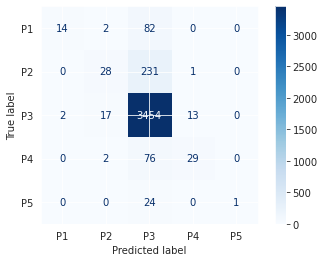

In [30]:
ConfusionMatrixDisplay.from_estimator(
    model1,
    X=X_test_tf,
    y=Y_test, 
    values_format='d',
    cmap=plt.cm.Blues
)

plt.show()

An easy way to determine precision and recall for each category is to use the `classification_report` function from scikit-learn.

In [31]:
# Check precision and recall
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.88      0.14      0.25        98
          P2       0.57      0.11      0.18       260
          P3       0.89      0.99      0.94      3486
          P4       0.67      0.27      0.39       107
          P5       1.00      0.04      0.08        25

    accuracy                           0.89      3976
   macro avg       0.80      0.31      0.37      3976
weighted avg       0.87      0.89      0.85      3976



While the recall and precision values for the class P3 are quite high, these values for the other classes are low and even 0 in some cases (P5). The overall accuracy of the model is 88%, but if we hard-coded our prediction to always be P3, this would also be correct 88% of the time. This makes it clear that our model has not learned much of significance and is merely predicting the majority class. This highlights the fact that during model evaluation we must analyze several metrics and not rely on the accuracy alone.

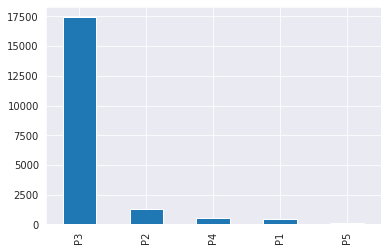

In [32]:
df['Priority'].value_counts().plot(kind='bar');

### Class Imbalance

The reason for the model to behave in this manner is due to the class imbalance in the priority classes that we observed earlier. While there were close to 36,000 bugs with a priority of P3, the number of bugs with other priority classes was only about 4,000 and even fewer in other cases. This means that when we trained our model, it was able to learn the characteristics of the P3 class alone.
 
Here, we randomly downsample the P3 class.

In [33]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

P3    4000
P2    1301
P4     534
P1     488
P5     127
Name: Priority, dtype: int64

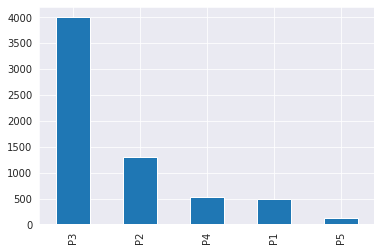

In [34]:
df_balanced['Priority'].value_counts().plot(kind='bar');

---
<a name='6.3'></a><a id='6.3'></a>
# 6.3 Final Blueprint for Text Classification
<a href="#top">[back to top]</a>

Here we combine all the steps we have listed so far to create our blueprint for text classification.

In [35]:
# Loading the balanced dataframe
df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text'],
    df['Priority'],
    test_size=0.2,
    random_state=42,
    stratify=df['Priority']
)
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation
X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  5160
Size of Test Data  1290
Accuracy Score -  0.6666666666666666
              precision    recall  f1-score   support

          P1       0.65      0.33      0.44        98
          P2       0.45      0.34      0.39       260
          P3       0.71      0.86      0.78       800
          P4       0.64      0.38      0.48       107
          P5       0.88      0.28      0.42        25

    accuracy                           0.67      1290
   macro avg       0.67      0.44      0.50      1290
weighted avg       0.65      0.67      0.64      1290



In [36]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.43488372093023253


### Examples where the model predictions for these priorities are accurate.

In [37]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
34888,breakpoint performance tests The peformance te...,P1,P1
1436,Breakpoints remain installed after target term...,P1,P1


### Examples where the model predictions for these priorities are NOT accurate:

In [38]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
3380,Severe shutdown performance problem Build 2002...,P1,P3
8656,use super type: problems with arrays see tests...,P2,P3


---
<a name='6.4'></a><a id='6.4'></a>
# 6.4 Blueprint: Using Cross-Validation to Estimate Realistic Accuracy Metrics
<a href="#top">[back to top]</a>

In [39]:
# Vectorization
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
# Use the entire dataset, not just the train split
df_tf = tfidf.fit_transform(df['text']).toarray()

# Cross Validation with 5 folds
scores = cross_val_score(
    estimator=model1,
    X=df_tf,
    y=df['Priority'],
    cv=5
)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.67131783 0.67906977 0.67054264 0.68217054 0.69224806]
Mean value across of validation scores  0.6790697674418604
Standard deviation of validation scores  0.007950934204625202


---
<a name='6.5'></a><a id='6.5'></a>
# 6.5 Blueprint: Performing Hyperparameter Tuning with Grid Search
<a href="#top">[back to top]</a>

### Requires a long time to run.

In [40]:
# Stop execution here

# assert(False)

In [41]:
%%time

# This takes a long time to run.

training_pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer(stop_words="english")), 
        ('model', LinearSVC(random_state=21, tol=1e-5))
    ]
)

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
gridSearchProcessor = GridSearchCV(
    estimator=training_pipeline,
    param_grid=grid_param,
    cv=5,
    verbose=3
)

gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END model__loss=hinge, model__max_iter=10000, model__penalty=l2, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.677 total time=   3.4s
[CV 2/5] END model__loss=hinge, model__max_iter=10000, model__penalty=l2, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.688 total time=   3.2s
[CV 3/5] END model__loss=hinge, model__max_iter=10000, model__penalty=l2, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.676 total time=   2.7s
[CV 4/5] END model__loss=hinge, model__max_iter=10000, model__penalty=l2, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.680 total time=   2.9s
[CV 5/5] END model__loss=hinge, model__max_iter=10000, model__penalty=l2, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.689 total time=   2.7s
[CV 1/5] END model__loss=hinge, model__max_iter=10000, model__penalty=l2, tfidf__min_df=5, tfidf__ngram_range=(1, 6);, score=0.681 total time=   7.2s
[CV 2/5] END model__loss=hinge, model_

In [42]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
9,1,0.705426,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."
5,2,0.705116,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__mi..."
8,3,0.703256,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."
4,4,0.703101,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__mi..."
1,5,0.684806,"{'model__loss': 'hinge', 'model__max_iter': 10..."


---
<a name='6.6'></a><a id='6.6'></a>
# 6.6 Blueprint Recap and Conclusion
<a href="#top">[back to top]</a>

Here we apply the pattern for text classification to a different classification task.

We want to automatically identify which part of the software the bug belongs to: Core, UI, and Doc.

We update the blueprint with the following changes:

* Additional step to include grid search to identify the best hyperparameters and limit the number of options tested to increase runtime.
* Additional option to use the sklearn.svm.SVC function to compare performance and try nonlinear kernels.

In [63]:
%%time

# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True

if runSVC:
    print("Using SVC algorithm")
else:
    print("Using LinearSVC algorithm")

HR()


# Loading the dataframe
file = "eclipse_jdt.csv.gz"

# GB: Create smaller dataset to ensure reasonable run-times on COLAB-CPU
df_orig = pd.read_csv(file)


### Using SVC algorithm

# This takes around 4min (SVC COLAB-CPU) if we use a reduced dataset.
# df = df_orig.sample(n=20_000, replace=True, random_state=42)

# This takes 7min 13s (SVC COLAB-CPU) 
# df = df_orig.sample(n=30_000, replace=True, random_state=42)

# This takes 12min 55s (SVC  COLAB-CPU) 
# df = df_orig.sample(n=40_000, replace=True, random_state=42)

# Original dataset: This takes 16min 47s(SVC COLAB-CPU) 
# df = df_orig


### Using LinearSVC algorithm

# Original dataset: 45min 39s　(LinearSVC COLAB-CPU, full dataset, 45K) 
df = df_orig




df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])


# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

if (runSVC):    
    # Sample the data when running SVC to ensure reasonable run-times
    df = (
        df
        .groupby('Component', as_index=False)
        .progress_apply(pd.DataFrame.sample, random_state=42, frac=.2)
    )


# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text'], # X
    df['Component'], # y
    test_size=0.2,
    random_state=42,
    stratify=df['Component']
)
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])


# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")

if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)]
)

gridSearchProcessor = GridSearchCV(
    estimator=training_pipeline,
    param_grid=grid_param,
    cv=5,
    verbose=3
)

gridSearchProcessor.fit(X_train, Y_train)

HR()

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_


# Step 4 - Model Evaluation
Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Using LinearSVC algorithm
----------------------------------------
Size of Training Data  36036
Size of Test Data  9009
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.790 total time=  27.8s
[CV 2/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.793 total time=  27.1s
[CV 3/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.790 total time=  29.6s
[CV 4/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.796 total time=  27.2s
[CV 5/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 3);, score=0.795 total time=  31.8s
[CV 1/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 6);, score=0.791 total time= 1.2min
[CV 2/5] END model__C=1, model__loss=hinge, tfidf__min_df=5, tfidf__ngram_range=(1, 6);, score=0.794

Best alpha parameter identified by grid search:
    
    {
        'model__C': 1, 
        'model__kernel': 'linear', 
        'tfidf__min_df': 5, 
        'tfidf__ngram_range': (1, 6)
    }

In [64]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.3852813852813853


In [65]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)

result[result['actual'] == result['predicted']].sample(2, random_state=21)

,text,actual,predicted
1468,Breakpoints are inconsistent before saveWhen e...,Debug,Debug
41133,PatternSearchJob ignores participant index ent...,Core,Core


In [66]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

,text,actual,predicted
11180,Code template preference pageI20030206; ; open...,UI,Text
12904,Change in SourceElementRequestorAdapterHCR has...,Debug,Core


In [67]:
# Check size of final dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45045 entries, 0 to 45295
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Component  45045 non-null  object
 1   text       45045 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
